In [1]:
# Uncomment and run this cell if you don't have DEAP or matplotlib installed (or haven't ran requirements.txt yet).
# !pip install deap matplotlib matplotlib

In [2]:
# Import necessary libraries
import random

import matplotlib.pyplot as plt
from deap import base, creator, tools

import data_store.street_fighter.letters as letters

In [3]:
# Set letters to the desired value
LETTERS = letters.SIMPLE_LETTERS

In [4]:
# Define fitness function
def calculate_distance(layout, frequencies):
    positions = {letter: idx for idx, letter in enumerate(layout)}
    total_distance = 0
    for letter1 in frequencies:
        if letter1 not in positions:
            print(f"Warning: Missing key '{letter1}' in positions.")
            continue
        for letter2 in frequencies:
            if letter2 not in positions:
                print(f"Warning: Missing key '{letter2}' in positions.")
                continue
            if letter1 != letter2:
                dist = abs(positions[letter1] - positions[letter2])
                total_distance += frequencies[letter1] * frequencies[letter2] * dist
    return total_distance,

In [5]:
# Create the Optimization Problem
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)


In [6]:
# Define a Custom Crossover Function
def cxOnePoint(ind1, ind2):
    if len(ind1) != len(ind2):
        raise ValueError("Individuals must have the same length.")
    
    size = len(ind1)
    cxpoint = random.randint(1, size - 1)  # Ensure cxpoint is within range

    ind1[cxpoint:], ind2[cxpoint:] = ind2[cxpoint:], ind1[cxpoint:]
    return ind1, ind2


In [7]:
# Define a Custom Mutation Function
def mutShuffleIndexes(individual, indpb):
    """Shuffle mutation for list-based individuals."""
    size = len(individual)
    for i in range(size):
        if random.random() < indpb:
            j = random.randint(0, size - 1)
            individual[i], individual[j] = individual[j], individual[i]
    return individual,

In [8]:
# Initialize Individuals and Population
def init_individual():
    # Initialize an individual with a random permutation of the letters
    layout = LETTERS[:]
    random.shuffle(layout)
    return creator.Individual(layout)

toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, lambda: random.sample(LETTERS, len(LETTERS)))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [9]:
# Define the Genetic Operators
toolbox.register("evaluate", calculate_distance, frequencies={
    "→": 10, "←": 15, "↑": 10, "↓": 10, "LP": 10, "MP": 5, "HP": 5, "LK": 10, "MK": 5, "HK": 5
})
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

In [10]:
# Evaluate Invalid Fitness
def evaluate_population(population, toolbox):
    for ind in population:
        if not ind.fitness.valid or len(ind.fitness.values) == 0:
            ind.fitness.values = toolbox.evaluate(ind)
            if not isinstance(ind.fitness.values, tuple) or len(ind.fitness.values) == 0:
                print(f"Warning: Fitness values for individual {ind} are invalid or empty")
    return population


In [11]:
# Debug Fitness Values
def debug_fitness(population):
    for ind in population:
        if not isinstance(ind.fitness.values, tuple):
            print(f"Warning: Fitness values for individual {ind} are not a tuple")
        if len(ind.fitness.values) == 0:
            print(f"Warning: Fitness values for individual {ind} are empty")
        else:
            print(f"Individual: {ind}, Fitness: {ind.fitness.values}")


In [12]:
def main():
    # Set DEAP parameters
    population = toolbox.population(n=100)
    NGEN = 50
    CXPB, MUTPB = 0.5, 0.2

    print("Starting the optimization")

    best_individual = None
    best_fitness = float('inf')

    for gen in range(NGEN):
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                try:
                    toolbox.mate(child1, child2)
                except IndexError as e:
                    print(f"IndexError during mating: {e}")
                    print(f"Child1: {child1}, Child2: {child2}")
                    continue
                del child1.fitness.values
                del child2.fitness.values

        # Apply mutation
        for mutant in offspring:
            if random.random() < MUTPB:
                try:
                    toolbox.mutate(mutant)
                except IndexError as e:
                    print(f"IndexError during mutation: {e}")
                    print(f"Mutant: {mutant}")
                    continue
                del mutant.fitness.values

        # Evaluate fitness values
        population = evaluate_population(population, toolbox)
        debug_fitness(population)

        # Update the population
        population[:] = toolbox.select(population + offspring, len(population))

        # Print statistics and track the best individual
        try:
            fits = [ind.fitness.values[0] for ind in population]
        except IndexError as e:
            print(f"IndexError while accessing fitness values: {e}")
            print(f"Population fitness values: {[ind.fitness.values for ind in population]}")
            continue

        length = len(population)
        mean = sum(fits) / length
        sum2 = sum(x*x for x in fits)
        std = abs(sum2 / length - mean**2)**0.5

        # Find the best individual
        current_best = min(population, key=lambda ind: ind.fitness.values[0])
        current_best_fitness = current_best.fitness.values[0]
        if current_best_fitness < best_fitness:
            best_fitness = current_best_fitness
            best_individual = current_best

        print(f"Generation {gen}: Min {min(fits)} | Max {max(fits)} | Avg {mean} | Std {std}")

    print(f"Best Individual: {best_individual}")
    print(f"Best Fitness: {best_fitness}")

    return best_individual, best_fitness

In [13]:
best_individual, best_fitness = main()

Starting the optimization
Individual: ['MP', 'LP', '→', '←', '↓', 'HP', 'HK', 'MK', 'LK', '↑'], Fitness: (23400.0,)
Individual: ['MP', '↑', 'HP', '→', 'MK', 'HK', '↓', '←', 'LK', 'LP'], Fitness: (23500.0,)
Individual: ['HK', 'MP', 'HP', '↓', '↑', 'MK', '→', 'LP', '←', 'LK'], Fitness: (22500.0,)
Individual: ['→', '←', 'LP', '↓', 'MP', 'LK', 'HP', 'HK', 'MK', '↑'], Fitness: (24300.0,)
Individual: ['MP', 'HP', 'HK', '→', 'LK', 'LP', '←', '↓', '↑', 'MK'], Fitness: (20400.0,)
Individual: ['↓', 'MP', '←', 'LK', 'HK', 'LP', 'MK', '↑', '→', 'HP'], Fitness: (23300.0,)
Individual: ['MP', '←', 'LP', 'HP', '→', 'HK', '↑', '↓', 'LK', 'MK'], Fitness: (23200.0,)
Individual: ['LP', '→', 'MK', '←', 'HP', 'MP', 'HK', '↓', '↑', 'LK'], Fitness: (25200.0,)
Individual: ['LK', '←', '↑', 'HP', 'MK', '→', 'MP', 'HK', '↓', 'LP'], Fitness: (25600.0,)
Individual: ['HP', '←', '→', 'MK', 'LK', 'MP', '↑', 'HK', 'LP', '↓'], Fitness: (24400.0,)
Individual: ['HK', 'MP', '→', '↑', 'LK', 'HP', 'MK', 'LP', '↓', '←'], Fitn

In [14]:
# Create a visualisation function
def visualize_layout(layout):
    fig, ax = plt.subplots(figsize=(10, 2))  # Adjust the size as needed
    y = [0] * len(layout)
    x = list(range(len(layout)))

    # Create a scatter plot
    ax.scatter(x, y, s=1000, color='skyblue', edgecolors='black')

    # Annotate each point with the letter
    for i, letter in enumerate(layout):
        ax.annotate(letter, (x[i], y[i]), ha='center', va='center', fontsize=12)

    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_title('Layout Visualization')
    plt.show()

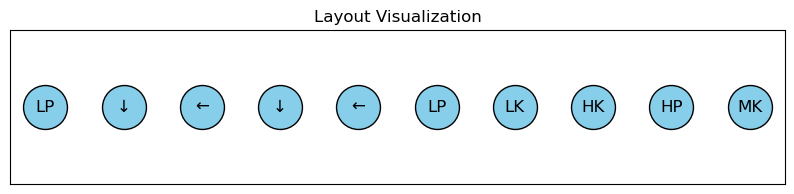

In [15]:
# Visualize the best layout
visualize_layout(best_individual)